# **Modeling and Evaluation (Regression) Notebook**

## Objectives
- Fit and evaluate a regression model to predict the Sales Price for a house in Ames, Iowa

## Inputs
- outputs/data_collected/house_oricing_data.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in notebook 01 - 03.

## Outputs
- Train set
- Test set
- Data cleaning and Feature Engineering pipeline
- Modeling pipeline


---

## Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices'

---

## Step 1: Load data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/data_collected/house_pricing_data.csv")  
  )

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

## Step 2a: ML Pipeline (Data Cleaning and Feature Engineering) with all relevant data

Set up ML pipeline for Data Cleaning and Feature Engineering

In [ ]:
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from src.preprocessing import drop_unwanted_columns
import joblib # to import preprocessing.py


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Drop unwanted columns
        ("DropUnwantedFeatures", FunctionTransformer(drop_unwanted_columns, validate=False)),

        # Impute MasVnrArea using mean
        ("ImputeMasVnrArea", MeanMedianImputer(imputation_method='mean', variables=['MasVnrArea'])),

        # Impute missing values in GarageFinish
        ("ImputeGarageFinish", CategoricalImputer(imputation_method='missing', variables=['GarageFinish'])),

        # Encoding categorical variables using OrdinalEncoder, add GarageFinish
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual', 'GarageFinish'])),

         # Feature selection based on correlation using SmartCorrelatedSelection
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=['GarageFinish', 'TotalBsmtSF', 'MasVnrArea', 'OpenPorchSF', '1stFlrSF', 'KitchenQual', 'YearRemodAdd', 'YearBuilt', 'GarageArea'],
         method="spearman", threshold=0.6, selection_method="variance")),

        # Apply log10 transformation to selected numeric features
        # SalePrice is removed due to X_train data
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))

    ], verbose=True)

    return pipeline_base


# Run the pipeline
PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('DropUnwantedFeatures',
                 FunctionTransformer(func=<function drop_unwanted_columns at 0x7482927a54e0>)),
                ('ImputeMasVnrArea',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MasVnrArea'])),
                ('ImputeGarageFinish',
                 CategoricalImputer(variables=['GarageFinish'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                var...arageFinish'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['GarageFinish',
                                                     'TotalBsmtSF',
                                                     'MasVnrArea',
                                                     'OpenPorchSF', '1stFlrSF',
                                                     'KitchenQual',
                                                     'YearRemodAdd',
                                                     'YearBuilt',
                                                     'GarageArea'])),
                ('LogTransformation',
                 LogTransformer(base='10', variables=['GrLivArea']))],
         verbose=True)

In [14]:
# 1. Get the pipeline
pipeline = PipelineDataCleaningAndFeatureEngineering()

# 2. Fit and transform  DataFrame
df_transformed = pipeline.fit_transform(df)

# 3. View the result
print(df_transformed.head())

[Pipeline]  (step 1 of 6) Processing DropUnwantedFeatures, total=   0.0s
[Pipeline] .. (step 2 of 6) Processing ImputeMasVnrArea, total=   0.0s
[Pipeline]  (step 3 of 6) Processing ImputeGarageFinish, total=   0.0s
[Pipeline]  (step 4 of 6) Processing OrdinalCategoricalEncoder, total=   0.0s
[Pipeline]  (step 5 of 6) Processing SmartCorrelatedSelection, total=   0.0s
[Pipeline] . (step 6 of 6) Processing LogTransformation, total=   0.0s
   BsmtFinSF1  GarageArea  GarageFinish  GrLivArea  KitchenQual  MasVnrArea  \
0         706         548             0   3.232996            0       196.0   
1         978         460             0   3.101059            1         0.0   
2         486         608             0   3.251881            0       162.0   
3         216         642             1   3.234770            0         0.0   
4         655         836             0   3.342028            0       350.0   

   OpenPorchSF  OverallQual  TotalBsmtSF  YearBuilt  SalePrice  
0           61     

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


In [15]:
df_transformed.head()

,BsmtFinSF1,GarageArea,GarageFinish,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,SalePrice
0,706,548,0,3.232996,0,196.0,61,7,856,2003,208500
1,978,460,0,3.101059,1,0.0,0,6,1262,1976,181500
2,486,608,0,3.251881,0,162.0,42,7,920,2001,223500
3,216,642,1,3.234770,0,0.0,35,7,756,1915,140000
4,655,836,0,3.342028,0,350.0,84,8,1145,2000,250000


### Train-test split after transforming the target

X_train and y_train will be used to train the model.
X_test and y_test will be used to evaluate the model.

X set is dropping 'SalePrice' since it is the target variable.
Y contains only the target variable.

In [16]:
from sklearn.model_selection import train_test_split

# Transform target variable
y_log = np.log10(df['SalePrice'])

# Split into features and target
X = df.drop('SalePrice', axis=1) # All columns except 'SalePrice' are features

# Split into train and test sets (80% train, 20% test is common)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)

### Apply the pipeline to training and testing features

In [17]:
pipeline = PipelineDataCleaningAndFeatureEngineering()

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

[Pipeline]  (step 1 of 6) Processing DropUnwantedFeatures, total=   0.0s
[Pipeline] .. (step 2 of 6) Processing ImputeMasVnrArea, total=   0.0s
[Pipeline]  (step 3 of 6) Processing ImputeGarageFinish, total=   0.0s
[Pipeline]  (step 4 of 6) Processing OrdinalCategoricalEncoder, total=   0.0s
[Pipeline]  (step 5 of 6) Processing SmartCorrelatedSelection, total=   0.0s
[Pipeline] . (step 6 of 6) Processing LogTransformation, total=   0.0s
(1168, 10) (1168,) (292, 10) (292,)


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype 

* 1168 training samples  and 292 test samples are created

### Check Target Imbalance

Check Target distribution of Train Set --> target shouldn't be imbalance because of the numeric tranformation of sales price (log10)

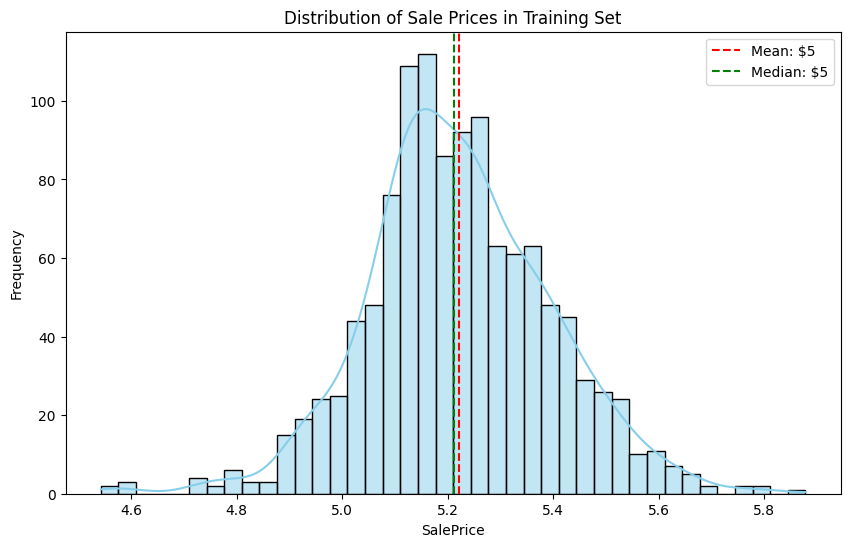

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=40, kde=True, color='skyblue')
plt.axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: ${y_train.mean():,.0f}')
plt.axvline(y_train.median(), color='green', linestyle='--', label=f'Median: ${y_train.median():,.0f}')
plt.title("Distribution of Sale Prices in Training Set")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Check Target distribution to show true sale price distribution. Reverse-transform log SalePrice

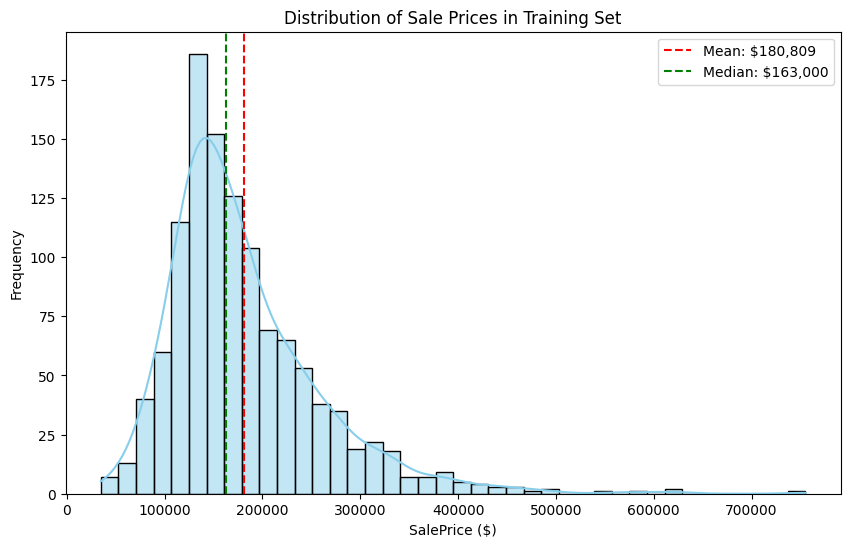

In [13]:
import numpy as np

# Reverse transform log values to actual dollar values
y_train_actual = np.power(10, y_train)

plt.figure(figsize=(10, 6))
sns.histplot(y_train_actual, bins=40, kde=True, color='skyblue')
plt.axvline(y_train_actual.mean(), color='red', linestyle='--', label=f'Mean: ${y_train_actual.mean():,.0f}')
plt.axvline(y_train_actual.median(), color='green', linestyle='--', label=f'Median: ${y_train_actual.median():,.0f}')
plt.title("Distribution of Sale Prices in Training Set")
plt.xlabel("SalePrice ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

---

## Step 2b: ML Pipeline (Regression model) with all relevant data

Set up ML pipeline for regression modeling and predicting the sales price

In [18]:
# import pandas as pd

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

def PipelineRegressor(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

### Hyperparameter Optimisation

Use GridSearch algorithm to find the best combination of hyperparameters for the model.

In [19]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineRegressor(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns]

### Hyperparameter Optimization Search (Grid Search)

1. Test multiple Algorithms and choose the best one.
2. Run multiple Hyperparameter on the selected algorithm to identify the best Hyperparameter.
3. Define best Algorithm (model) and best Hyperparameter

#### 1. Test multiple algorithms with Grid Search CV

In [20]:
# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

# Algorithms that will be used/ tested
models_quick_search = {
    "XGBRegressor": XGBRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
}

# Define hyperparameter for each algorithm
# empty {} means default hyperparameter will be used
params_quick_search = {
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}

Apply algorithms to Train data

In [21]:
# Start HyperparameterOptimizationSeach
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fit model with training data
search.fit(X_train, y_train,
           scoring = 'neg_mean_absolute_error',
           n_jobs=-1, cv=5)

# To check the results:
search.score_summary(sort_by='mean_score')


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,estimator,min_score,mean_score,max_score,std_score
4,ExtraTreesRegressor,-0.062386,-0.056811,-0.050577,0.003993
3,GradientBoostingRegressor,-0.069595,-0.066239,-0.062773,0.002371
0,XGBRegressor,-0.077575,-0.069641,-0.064789,0.004279
2,RandomForestRegressor,-0.075976,-0.072316,-0.066196,0.003315
5,AdaBoostRegressor,-0.079534,-0.076377,-0.065951,0.005239
1,DecisionTreeRegressor,-0.089899,-0.083047,-0.076155,0.004376


---

### 2. Define model and test multiple Hyperparameter

Based on the results ExtraTreesRegressor model is the best working on. This one is selected. In the next steps the best hyperparameter set up is defined. 

In [22]:
# Initialize the ExtraTreesRegressor model
model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [23]:
# ExtraTreesRegressor
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

# Define hyperparameter for ExtraTreesRegressor
params_quick_search = {
    "ExtraTreesRegressor": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ['auto', 'sqrt', 0.5]
    }
}

Apply algorithm and various hyperparameter to test data

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd


# Start HyperparameterOptimizationSeach
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fit model with training data, scoring 'neg_mean_absolute_error', 'neg_root_mean_squared_error', or scoring='r2'
search.fit(X_train, y_train,
           scoring = 'neg_mean_absolute_error',
           n_jobs=-1, cv=5)

# To check the results:
search.score_summary(sort_by='mean_score')


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 4

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
274,ExtraTreesRegressor,-0.058972,-0.053359,-0.047638,0.003935,30,sqrt,1,5,200
301,ExtraTreesRegressor,-0.058972,-0.053359,-0.047638,0.003935,30,0.5,1,5,200
58,ExtraTreesRegressor,-0.058972,-0.053359,-0.047638,0.003935,None,0.5,1,5,200
31,ExtraTreesRegressor,-0.058972,-0.053359,-0.047638,0.003935,None,sqrt,1,5,200
230,ExtraTreesRegressor,-0.058113,-0.053443,-0.047305,0.00406,20,0.5,2,5,300
...,...,...,...,...,...,...,...,...,...,...
265,ExtraTreesRegressor,NaN,NaN,NaN,NaN,30,auto,4,5,200
266,ExtraTreesRegressor,NaN,NaN,NaN,NaN,30,auto,4,5,300
267,ExtraTreesRegressor,NaN,NaN,NaN,NaN,30,auto,4,10,100
268,ExtraTreesRegressor,NaN,NaN,NaN,NaN,30,auto,4,10,200


---

### 3. Define best model and best Hyperparameter set up

In [25]:
from sklearn.ensemble import ExtraTreesRegressor # already imported on top

# Initialize the ExtraTreesRegressor model
pipeline_regressor = ExtraTreesRegressor(
    max_depth=20,
    max_features=0.5,
    min_samples_split=5,
    min_samples_leaf=2,
    n_estimators=100,   
)

# Fit the model on the training data
pipeline_regressor.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=2,
                    min_samples_split=5)

### Make Predictions and Evaluate the Model

In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 1. Predict (still in log scale)
y_pred_log = pipeline_regressor.predict(X_test)

# 2. Inverse transform both predictions and test target
y_pred = np.power(10, y_pred_log)
y_test_actual = np.power(10, y_test)

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = mean_squared_error(y_test_actual, y_pred, squared=False)
r2 = r2_score(y_test_actual, y_pred)


print(f"Mean Absolute Error (MAE): ${mae:,.0f}")
print(f"Mean Squared Error (MSE): {mse:,.0f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.0f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): $19,778
Mean Squared Error (MSE): 1,247,508,120
Root Mean Squared Error (RMSE): $35,320
R² Score: 0.8194


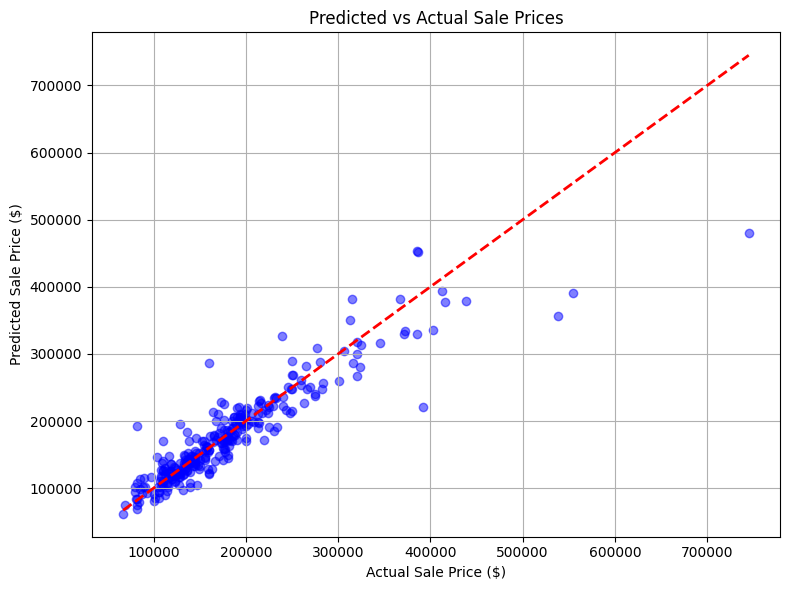

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.5, color='blue')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         color='red', lw=2, linestyle='--')  # ideal line

plt.title("Predicted vs Actual Sale Prices")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Access Feature importance

In [16]:
X_train.head(3)

,BsmtFinSF1,GarageArea,GarageFinish,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt
618,48,774,0,3.261976,0,452.0,108,9,1822,2007
870,0,308,1,2.951338,1,0.0,0,5,894,1962
92,713,432,0,2.984077,1,0.0,0,5,876,1921


* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt']


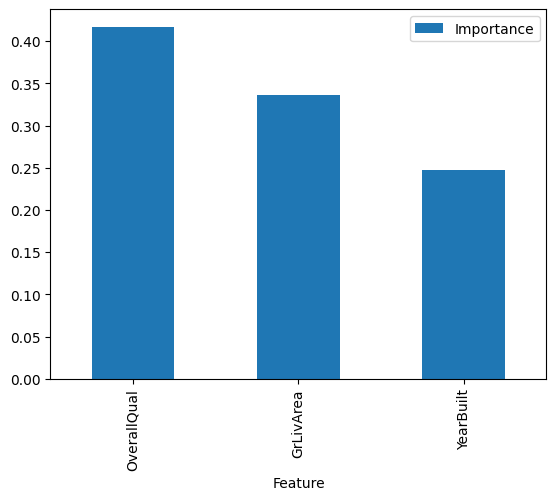

In [17]:
# Feat Selection
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import matplotlib.pyplot as plt

# Wrap the model inside your pipeline
pipeline_regressor = PipelineRegressor(ExtraTreesRegressor(n_estimators=100, random_state=42))

#Fit model
pipeline_regressor.fit(X_train, y_train)

feat_selector = pipeline_regressor.named_steps['feat_selection']
model = pipeline_regressor.named_steps['model']

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[feat_selector.get_support()],
    'Importance': model.feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Get list of important features
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()



---

## Step 3: Refine pipeline with best features

The three most important features are used for the optimized pipeline:
'GrLivArea', 'OverallQual', 'YearBuilt'

DUe to testing following features will be added:


irrelevant variables:
MarVarSF, GarageArea, BsmtFinSF1, GarageFinish, KitchenQual, OverallQual, TotalBsmtSF, YearRemodAdd, SalePrice(for x_train and test data)

### Apply Data Cleaning and Feature Engineering

Delete further unwanted variables due to SmartCorrelation and feature importance check

In [45]:
df_opt = df_transformed.drop(columns=['BsmtFinSF1', 'KitchenQual', 'TotalBsmtSF', 'GarageFinish', 'GarageArea', 'MasVnrArea'])
# 'OpenPorchSF' is kept

In [46]:
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection # Import SmartCorrelationSelection
from feature_engine.encoding import OrdinalEncoder # Import OrdinalEncoder
from feature_engine.transformation import LogTransformer  # Import LogTransformer
from feature_engine.imputation import MeanMedianImputer # For Imputation
from src.preprocessing import drop_unwanted_columns
import joblib # to import preprocessing.py


def PipelineDataCleaningAndFeatureEngineering_opt():
    pipeline_opt = Pipeline([
        # Function Transformer not needed anymore

        # Impute GarageFinish using mode most frequent, not needed anymore
        # ("ImputeGarageFinish", CategoricalImputer(imputation_method='frequent', variables=['GarageFinish'])),

        # Impute MasVnrArea using mean, not needed anymore
        # ("ImputeMasVnrArea", MeanMedianImputer(imputation_method='mean', variables=['MasVnrArea'])),

        # Encoding categorical
        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     # variables=['GarageFinish'])),

        # SmartCorrelatedSelection, not needed anymore

        # Apply log10 transformation to selected numeric features
        # SalePrice is removed due to X_train data
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))

    ])

    return pipeline_opt


# Run the pipeline
PipelineDataCleaningAndFeatureEngineering_opt()

Pipeline(steps=[('LogTransformation',
                 LogTransformer(base='10', variables=['GrLivArea']))])

### Train-test split after transforming the target and other parameters

In [47]:
from sklearn.model_selection import train_test_split

# Transform target variable
df_opt['SalePrice'] = np.log10(df_opt['SalePrice'])

# Ensure GarageFinish is treated as categorical
# df_opt['GarageFinish'] = df_opt['GarageFinish'].astype('object')
# df_opt['GrLivArea'] = 10 ** df_opt['GrLivArea']

# Split into features and target
X = df_opt.drop('SalePrice', axis=1) # All columns except 'SalePrice' are features
y = df_opt['SalePrice'] # 'SalePrice' is the target variable

# Split into train and test sets (80% train, 20% test is common)
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X, y, test_size=0.2, random_state=0)

### Apply DC and FE pipeline to optimized training and testing features

In [48]:
pipeline_opt = PipelineDataCleaningAndFeatureEngineering_opt()

X_train_opt = pipeline_opt.fit_transform(X_train_opt)
X_test_opt = pipeline_opt.transform(X_test_opt)

print(X_train_opt.shape, y_train_opt.shape, X_test_opt.shape, y_test_opt.shape)

(1168, 4) (1168,) (292, 4) (292,)


### Apply regressor pipeline to optimized training and testing features

In [49]:
# Fit the model on the training data
pipeline_regressor.fit(X_train_opt, y_train_opt)

ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=2,
                    min_samples_split=5)

### Evaluate optimized regression pipeline:

In [50]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

# Predict (in log10 scale)
y_pred_opt_log = pipeline_regressor.predict(X_test_opt)

# 2. Inverse transform back to dollar
y_pred_opt = np.power(10, y_pred_opt_log)
y_test_opt_actual = np.power(10, y_test_opt)

# Evaluate the model in real dollar terms
mae = mean_absolute_error(y_test_opt_actual, y_pred_opt)
mse = mean_squared_error(y_test_opt_actual, y_pred_opt)
rmse = mean_squared_error(y_test_opt_actual, y_pred_opt, squared=False)
r2 = r2_score(y_test_opt_actual, y_pred_opt)


print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): $22,080.21
Mean Squared Error (MSE): 1,394,977,755.03
Root Mean Squared Error (RMSE): $37,349.40
R² Score: 0.7980


Latest scoring results:

* Mean Absolute Error (MAE): $21,690.49
* Mean Squared Error (MSE): 1,339,023,474.89
* Root Mean Squared Error (RMSE): $36,592.67
* R² Score: 0.806

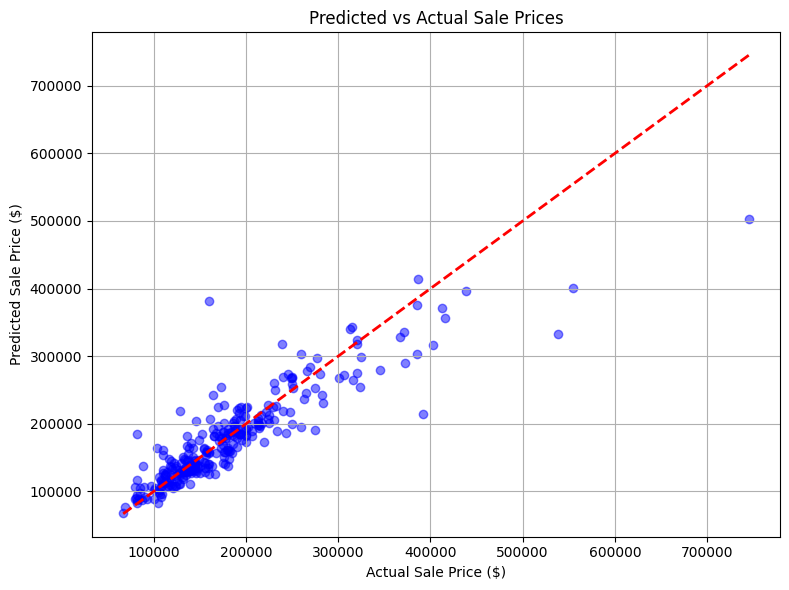

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_opt_actual, y_pred_opt, alpha=0.5, color='blue')
plt.plot([y_test_opt_actual.min(), y_test_opt_actual.max()],
         [y_test_opt_actual.min(), y_test_opt_actual.max()],
         color='red', lw=2, linestyle='--')  # ideal line

plt.title("Predicted vs Actual Sale Prices")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Residuals Plot

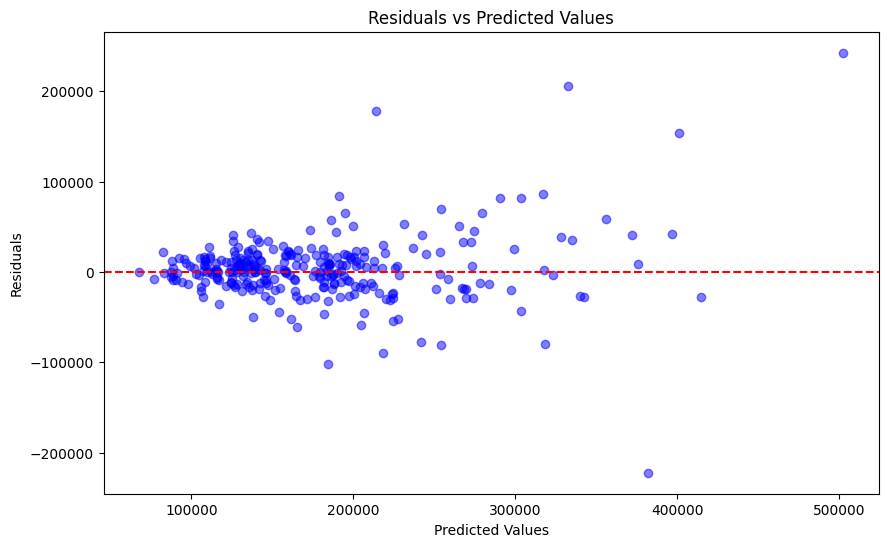

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# re-transform the Sale Price 
y_test = np.power(10, y_test_opt)

# Assuming there is a regression model and y_pred provided
residuals = y_test - y_pred_opt

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_opt, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

---

Test different model: GradientBoostingRegressor

---

##  Step 4: Push files to Repo

The following files will be generated:
- Train Set: X_train, y_train (2a)
- Train Set: X_train_opt, y_train_opt (2b)
- Test Set: X_test, y_test (2a) 
- Test Set: X_test_opt, y_test_opt(2b)
- Data cleaning and Feature Engineering pipeline
- Regressor pipeline

In [53]:
pipeline_dc_fe = pipeline
pipeline_dc_fe_opt = pipeline_opt

In [54]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipelines/predict_SalePrice/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipelines/predict_SalePrice/v1'


In [55]:
# Save trained models
joblib.dump(value=pipeline_dc_fe ,
            filename=f"{file_path}/pipeline_data_cleaning_feat.pkl")
joblib.dump(value=pipeline_dc_fe_opt,
            filename=f"{file_path}/pipeline_data_cleaning_feat_opt.pkl")
joblib.dump(value=pipeline_regressor,
            filename=f"{file_path}/pipeline_regressor.pkl")

['outputs/ml_pipelines/predict_SalePrice/v1/pipeline_regressor.pkl']

## Train Set

### Train Set with more features

In [56]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Train Set with best features

In [57]:

X_train_opt.to_csv(f"{file_path}/X_train_opt.csv", index=False)
y_train_opt.to_csv(f"{file_path}/y_train_opt.csv", index=False)

In [58]:
y_train_opt.head(3)

618    5.498053
870    5.039414
92     5.213518
Name: SalePrice, dtype: float64

In [59]:
X_train_opt.head(3)

,GrLivArea,OpenPorchSF,OverallQual,YearBuilt
618,0.513481,108,9,2007
870,0.470019,0,5,1962
92,0.474810,0,5,1921


## Test Set

### Test Set with more features

In [60]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Test Set with best features

In [61]:
X_test_opt.to_csv(f"{file_path}/X_test_opt.csv", index=False)
y_test_opt.to_csv(f"{file_path}/y_test_opt.csv", index=False)

In [62]:
y_test_opt.head(3)

529    5.302383
491    5.123852
459    5.041393
Name: SalePrice, dtype: float64

In [63]:
X_test_opt.head(3)

,GrLivArea,OpenPorchSF,OverallQual,YearBuilt
529,0.531548,0,6,1957
491,0.504893,0,6,1941
459,0.488588,0,5,1950


---

## Step 5: Combine Data Engineering and Regressor pipeline (in progress)

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("outputs/data_collected/house_pricing_data.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Assuming you already have SalePrice
y = df['SalePrice']

# Data cleaning: Drop specified columns and fill missing values for relevant columns
X = X.drop(columns=['BsmtFinType1', 'LotArea', 'BsmtFinType1', 'BsmtUnfSF', 'BedroomAbvGr', 'BsmtExposure', 'OverallCond', 'GarageYrBlt', 'LotFrontage', 'EnclosedPorch', 'WoodDeckSF', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', '2ndFlrSF', 'KitchenQual', 'GarageFinish'])

# Data cleaning: Fill missing values in 'MasVnrArea' column with the mean
X['MasVnrArea'] = X['MasVnrArea'].fillna(X['MasVnrArea'].mean())

# Data cleaning: Ensure the columns to which you will apply the log transformation are float64
X['GrLivArea'] = X['GrLivArea'].astype('float64')

# Define preprocessing steps
preprocessing = Pipeline([
        # Apply log10 transformation to selected numeric features
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))
    ])

# Combine preprocessing with model
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("pipline_regressor", pipeline_regressor)
    # ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('LogTransformation',
                                  LogTransformer(base='10',
                                                 variables=['GrLivArea']))])),
                ('pipline_regressor',
                 ExtraTreesRegressor(max_depth=20, max_features=0.5,
                                     min_samples_leaf=2,
                                     min_samples_split=5))])

### Model evaluation

In [70]:
y_pred = full_pipeline.predict(X_test)
from sklearn.metrics import r2_score

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Absolute Error (MAE): ${mae:,.0f}")
print(f"Mean Squared Error (MSE): {mse:,.0f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.0f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): $21,513
Mean Squared Error (MSE): 1,206,924,226
Root Mean Squared Error (RMSE): $34,741
R² Score: -0.7722


Save pipeline

In [ ]:
# Create folder if needed
model_path = "outputs/ml_pipelines/predict_SalePrice/v1"
os.makedirs(model_path, exist_ok=True)

# Save pipeline
joblib.dump(full_pipeline, f"{model_path}/full_pipeline.pkl")

['outputs/ml_pipelines/predict_SalePrice/v1/full_pipeline.pkl']